This notebook shows the steps of generating recommendations using ReviewTFIDF and ReviewLDAKL algorithms. The results are compared with multiple Collaborative Filtering algorithms. 

## Setup

#### Importing the components we need to run this notebook

In [88]:
import pandas as pd
import numpy as np
import nltk
import pickle
import parquet
import matplotlib.pyplot as plt
import ast
import gzip
from tqdm import tqdm_notebook as tqdm

#### Importing necessary lenskit components 

In [92]:
import lenskit
import lenskit.crossfold as xf
from lenskit.crossfold import TTPair

In [93]:
from lenskit.batch import MultiEval
from lenskit.crossfold import sample_users, SampleN
from lenskit import batch, topn, util

## Loading Data

#### Downloaded the Steam review dataset from https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data
Both "Review data" and "User and Item data" were downloaded. 

In [28]:
with gzip.open('data/australian_users_items.json.gz') as rf:
    user_records = pd.DataFrame.from_records(ast.literal_eval(line.decode('utf8')) for line in tqdm(rf))
#user_records.info()

In [30]:
user_records.head(2)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."


In [27]:
with gzip.open('data/australian_user_reviews.json.gz') as rf:
    user_reviews = pd.DataFrame.from_records(ast.literal_eval(line.decode('utf8')) for line in tqdm(rf))
#user_reviews.info()

In [31]:
user_reviews.head(2)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."


### Cleaning up

#### Not all the columns are needed for this experiments and to fit into lenskit module 'user_id' and 'items' columns need to be renamed to 'user' and 'item'.

In [86]:
def unpack_user_items(row):
    "Unpack item infromation from the items columns"
    
    new_df = pd.DataFrame.from_records(row.items)
    # now fix up data types
    new_df['item_id'] = new_df['item_id']
    new_df['user_id'] = row.user_id
    return new_df[['user_id', 'item_id', 'item_name']]

user_games = pd.concat((unpack_user_items(row)
                        for row in tqdm(user_records.itertuples(), total=len(user_records))
                        if len(row.items) > 0),
                       ignore_index=True)
#user_games.info()

In [87]:
def unpack_user_reviews(row):
    "Unpack item infromation from the items columns"
    
    new_df = pd.DataFrame.from_records(row.reviews)
    # now fix up data types
    new_df['review'] = new_df['review']
    new_df['user_id'] = row.user_id
    new_df['item_id'] = new_df.item_id
    return new_df[['user_id', 'item_id','review']]

game_reviews = pd.concat((unpack_user_reviews(row)
                        for row in tqdm(user_reviews.itertuples(), total=len(user_reviews))
                        if len(row.reviews) > 0),
                       ignore_index=True)
#game_reviews.info()

In [78]:
user_game = user_games.rename(columns={'user_id': 'user', 'item_id': 'item'})
user_games_list = user_game[['item', 'user']]
user_games_list.head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


In [84]:
reviews = game_reviews[['item_id', 'user_id','review']]
reviews = reviews.rename(columns={'user_id': 'user', 'item_id': 'item'})
reviews.head()

,item,user,review
0,1250,76561197970982479,Simple yet with great replayability. In my opi...
1,22200,76561197970982479,It's unique and worth a playthrough.
2,43110,76561197970982479,Great atmosphere. The gunplay can be a bit chu...
3,251610,js41637,I know what you think when you see this title ...
4,227300,js41637,For a simple (it's actually not all that simpl...


##### Selecting all the items that have reviews

In [79]:
rev_item = set(reviews['item'])   ## reviewed item
user_item = set(user_games_list['item'])  ##items in user item data 
item_with_rev = user_item.intersection(rev_item) ## items that have reviews
user_item_rev = user_games_list[user_games_list['item'].isin(list(item_with_rev))] 
result = pd.merge(user_item_rev, reviews, how = 'outer', on=['item', 'user'])

### Pruning 
Users who have less than 5 items in their list are removed. 

In [53]:
def groupby_count(df, group, count):
    game_count = pd.DataFrame()
    game_count['count'] = df.groupby(group)[count].nunique()
    return game_count

In [54]:
def prune(df, condition):     ## returns a dataframe that meet the given condition
    user_n = df.loc[df['count'] < condition ]
    return user_n

In [82]:
## user-item count
game_count = groupby_count(result, 'user', 'item')
game_count.sort_values(by = 'count', ascending = False).head()

,count
user,
phrostb,2698
chidvd,2514
piepai,2419
thugnificent,2373
DeEggMeister,1914


In [85]:
user_5 = prune(game_count, 5)
user_less_5 = user_5.index
pruned_data_5 = result.set_index('user').drop(user_less_5)
pruned_data_5.reset_index(inplace = True)
pruned_data_5.head()

,user,item,review
0,76561197970982479,10,NaN
1,76561197970982479,20,NaN
2,76561197970982479,30,NaN
3,76561197970982479,40,NaN
4,76561197970982479,50,NaN


In [97]:
pruned_data_5.describe()

,user,item,review
count,4249767,4249767,56292
unique,62023,3663,51270
top,phrostb,730,good game
freq,2698,42926,99


### Sampling
lenskit.crossfold module is used. 5 partitions of each size of 10000 samples are taken to create train-test sets.

In [94]:
pairs_user = list(sample_users(pruned_data_5, 5, 10000, xf.SampleN(1)))
truth = pd.concat((p.test for p in pairs_user))

### Loading Algorithms

To evaluate the performance of ReviewTFIDF an ReviewLDAKL algorithms, we compared the results with other existing algorithms. We used multiple collaboartive filtering algorithms: userKNN, itemKNN , Popular, ImplicitMF, BPR. Lenskit provides the interface for running these algorithms.

In [98]:
from lenskit.algorithms import als, basic, item_knn, user_knn
from lenskit.algorithms.als import ImplicitMF
from lenskit.algorithms.implicit import BPR

In [102]:
from TF_IDF import ReviewTFIDF
from LDA import ReviewLDAKL

### Generating Recommendations

#####  lenskit.batch function is used to generate recommendations for all the algorithms. For each user, 100 items are recommended.

In [4]:
def algo_eval(path, algo, dataset):
    evaluation = batch.MultiEval(path=path, predict=False, recommend=100, n_jobs = 12)
    evaluation.add_algorithms(algos=algo)
    evaluation.add_datasets(data=dataset)
    evaluation.run()

In [5]:
algo_ii = item_knn.ItemItem(20, center=False, aggregate='sum')
algo_uu = user_knn.UserUser(30, center=False, aggregate='sum')
algo_pop = basic.Popular()
algo_mf = ImplicitMF(40)
algo_bpr = BPR()
algo_tf_idf = ReviewTFIDF()
algo_LDA = ReviewLDAKL()

algo_eval('results/steam', [algo_ii, algo_uu, algo_pop, algo_mf, algo_bpr,algo_LDA, algo_tf_idf], pairs_user)

## Evaluation

#### Mean reciprocal rank (MRR) and recall are calculated for each algorithm. The results are shown in a bar plot. 

In [6]:
def score_By_user(rec, truth, metric):
    #recs = pd.read_parquet(file_name)
    rla = topn.RecListAnalysis()
    if metric == 'recip_rank':
        rla.add_metric(topn.recip_rank)
    if metric == 'recall':
        rla.add_metric(topn.recall)
    metric_result = rla.compute(rec, truth)
    return metric_result

In [7]:
def result_By_algo(rec, run, truth, metric):
    user_score = score_By_user(rec, truth, metric)
    
    algo_score = user_score.join(run, on='RunId')
    algo_score.reset_index(inplace = True)
    algo_mean_score = pd.DataFrame(algo_score.groupby(['AlgoStr'])[metric].mean())
    algo_mean_score.reset_index(inplace = True)
    return algo_mean_score

In [8]:
recommendations = pd.read_parquet('results/steam/recommendations.parquet')
legend = pd.read_csv("results/steam/runs.csv")
legend = legend.set_index('RunId').loc[:,'AlgoStr']

##### MRR

In [15]:
MRR = result_By_algo(recommendations, legend, truth, 'recip_rank')
MRR

,AlgoStr,recip_rank
0,Implicit(<implicit.bpr.BayesianPersonalizedRan...,0.144798
1,"ItemItem(nnbrs=20, msize=None)",0.152595
2,Popular,0.092962
3,"UserUser(nnbrs=30, min_sim=0)",0.196192
4,"als.ImplicitMF(features=40, reg=0.1, w=40)",0.107215
5,LDA,0.006735
6,Tf-IDF,0.046780


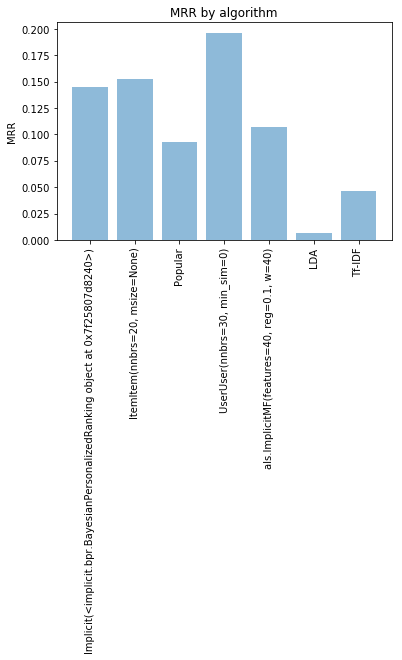

In [18]:
X = MRR['AlgoStr']
Y = MRR['recip_rank']

plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.xticks(rotation=90)
plt.ylabel('MRR')
plt.title('MRR by algorithm')

plt.show()

##### Recall

In [11]:
Recall = result_By_algo(recommendations, legend, truth, 'recall')
Recall

,AlgoStr,recall
0,Implicit(<implicit.bpr.BayesianPersonalizedRan...,0.55938
1,"ItemItem(nnbrs=20, msize=None)",0.58042
2,Popular,0.48460
3,"UserUser(nnbrs=30, min_sim=0)",0.67136
4,"als.ImplicitMF(features=40, reg=0.1, w=40)",0.67374
5,LDA,0.08958
6,Tf-IDF,0.38268


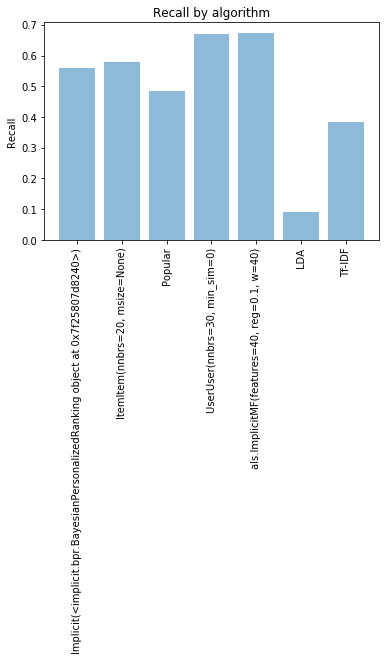

In [19]:
X = Recall['AlgoStr']
Y = Recall['recall']
plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.xticks(rotation=90)
plt.ylabel('Recall')
plt.title('Recall by algorithm')

plt.show()